In [1]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [2]:
from pipeline import Pipeline, MultiPipeline
from decoding_analysis import CVPipleline, LDADecoder, EEGDecoder, OvertimePipelineDecoder
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA
from mne_bids import BIDSPath
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import logging

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold

from mne.decoding import Vectorizer, cross_val_multiscore, SlidingEstimator, CSP

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Set BIDSPath

In [4]:
bids_root = os.path.join('data', 'P3');
bids_path = BIDSPath(subject='030', session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root);

## Initialize Pipeline and execute init actions

In [5]:
pipeline = Pipeline(bids_path, verbose=logging.ERROR);
pipeline.load_data();
pipeline.set_custom_events_mapping(task='P3');
pipeline.set_montage();
pipeline.make_pipeline([SimpleMNEFilter(0.1, 50, 'firwin'), CleaningData(bids_path), PrecomputedICA(bids_path)]);

We will initialize an object of `ERPAnalysis` which will have all the data regarding the ERP analysis, we will also run the pipeline till the processing step

# Decoding Analysis

## Fist, I will run the classifier on a single subject to find out which which is bettter

initialize the training data, and transform it using the CSP transformer

In [6]:
decoder = EEGDecoder('stimulus', (-0.1, 0.8), (0.1, 0.7), pipeline.raw)

we will use the CSP feature transformer to transform the feature

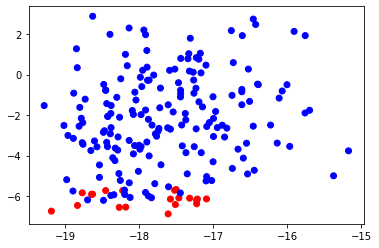

In [7]:
csp_data, labels = decoder.feature_transform();
plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red", "blue"])[np.where(labels == 1, 0, 1)])

In [8]:

lda = LDADecoder(); # Simple LDA classifier, training and fitting on the same data
lda.fit(csp_data, labels);
print('Accuracy of LDA classifier {}'.format(lda.predict(csp_data, labels))); 

Accuracy of LDA classifier 0.92


In [9]:
# Now, we will test the accuracy by training on test data and making prediction on test data
train_data, test_data, labels_train, labels_test = train_test_split(csp_data, labels, random_state=32);
lda.fit(train_data, labels_train);
print('Accuracy of LDA classifier {}'.format(lda.predict(test_data, labels_test)));

Accuracy of LDA classifier 0.88



We will also use Precision, Recall, and F1-score to evalutae our performance because Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes.

Reference: http://mlwiki.org/index.php/Precision_and_Recall

In [10]:
lda_cv_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'));
lda = CVPipleline(lda_cv_pip, train_data, test_data, labels_train, labels_test); # our own class; for reference look at the decoding.py
lda.fit();
lda.predict();
lda.evaluate();

Clasification Report:
               precision    recall  f1-score   support

        Rare       1.00      0.14      0.25         7
    Frequent       0.88      1.00      0.93        43

    accuracy                           0.88        50
   macro avg       0.94      0.57      0.59        50
weighted avg       0.89      0.88      0.84        50

Accuracy of model: 0.88
Precision: 0.9387755102040816, Recall: 0.5714285714285714, f1-score:0.5923913043478262


No Comments on scores

## CrossValidation and Extension (using Sklearn Pipeline)

The purpose of using Vectorizer is to convert EEG data from (n_epochs, n_channels, n_times) structure to a vector of (samples, channels) form. Moreover, we will use StandardScaler() to remove the mean and scale to unit variance. StandardScaler standardizes our data feature-wise by the formulation of z = (x - u) / s. In this formula, u is the mean of the feature and s is the standard deviation of the same feature. By applying this technique, each feature's mean and standard deviation will become zero and one respectively. Standardization of features, which are eeg channels in our case, prevent domination of a channel(or a feature) just becuase it contains larger variation.


## Without using feature transformation

we will use the `SVM` to classify our stimulus without doing feature transform CSP data

In [11]:
# Now we will use only two channels
data, labels = decoder.get_train(channels=['Cz', 'CPz']) # get training data using decoder.py
clf_svm = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(kernel='linear', C=1))
scores = cross_val_score(clf_svm, data, labels, cv=5);
for i in range(len(scores)):
    print('Accuracy of ' + str(i+1) + 'th fold is ' + str(scores[i]));
print('Mean accuracy {}'.format(np.mean(scores)));

Accuracy of 1th fold is 0.9
Accuracy of 2th fold is 0.9
Accuracy of 3th fold is 0.9
Accuracy of 4th fold is 0.9
Accuracy of 5th fold is 0.9
Mean accuracy 0.9


## Hyperparameter Optimization

SVM performs even better, but we are usign fixed parameters. Sometimes, it is not easy to decide which are the best parameters for our model. That's why we will use now hyperparameter optimization technique to find out the best kernels and constant value

Another option is GridSearchCV which searchs the best performing parameters among the given list of possible parameter values exhaustedly. You can specify the scoring method and cross validation strategy inside GridSearchCV.

In the following example StratifiedKFold strategy is selected. The benefit of using this strategy is that it divides data into folds with approxiamtely same percentage of classes as the whole dataset.


In [12]:
#svm
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42));
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True);

In [13]:
data, labels = decoder.get_train();
# train_data, test_data, labels_train, labels_test = train_test_split(csp_data, labels);
gs_cv_svm.fit(data, labels)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.9


Although accuracy is one of the most common evaluation metrics for machine learning models, it is not enough to conclude a model is performing than another. It may be deceptive in some cases. For example when a model classifies a majority of the instances to one class, accuracy can still be high if the classes are highly imbalanced. Another case would be when false postive and false negative have different consequences. Especially in the medical domain, this case is an important aspect while evaluating models. Therefore, precision, recall and f1-score, which is a metric combining precision and recall, should be considered besides accuracy.

### Is there someting missing? - Yes! - Unbalanced number of classes - We will discuss this later when we have more data

<AxesSubplot:>

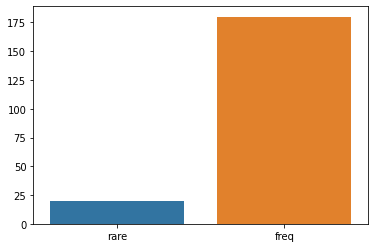

In [14]:
sns.barplot(x=['rare', 'freq'], y=[len(np.where(labels == 1)[0]), len(np.where(labels == 2)[0])])

## Classification Over time (for a single subject, we will later do further analysis)

In [15]:
timeDecode = SlidingEstimator(clf_svm);
epch_train = decoder.epochs.load_data().copy().resample(60)
scores = cross_val_multiscore(timeDecode, epch_train.get_data(), labels, cv=StratifiedKFold(n_splits=5), n_jobs=2);
print('Accuracy score {}'.format(np.mean(scores)));

Accuracy score 0.7956944444444446


In [16]:
tsr = decoder.run_sliding_()

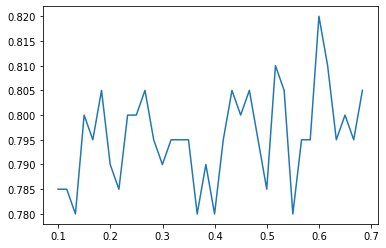

In [17]:
plt.plot(tsr[0],tsr[1].mean(axis=0));

In [18]:
scores.shape, epch_train.tmin, epch_train.tmax

((5, 36), 0.099609375, 0.6829427083333334)

Plotting scores over time

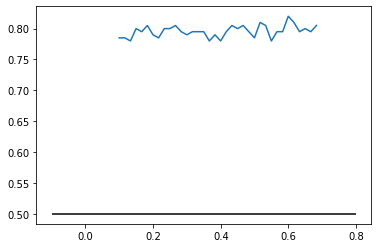

In [19]:
plt.plot(epch_train.times,scores.mean(axis=0));
plt.hlines(0.5,-0.1,0.8,'k');

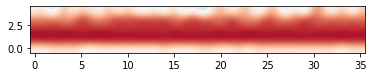

In [20]:
scores.shape
im = plt.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',vmin=0.2, vmax=1);
# plt.colorbar()

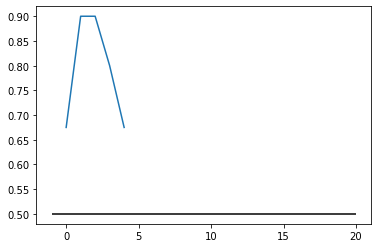

In [21]:
plt.plot(np.diag(scores));
plt.hlines(0.5,-1,20,'k');

# Analysing classification scores of different subjects by aggregating their `mne.io.Raw`

I think the problem with the above approach is imbalanced number or rare and frequent events in our epochs. Ideally we should have 50-50 samples for both rare and frequent events. But for a single subject this seems not possible because we have too few examples

To circumvent this problem, 
 - we will load all the subject data in one raw object using raw.concate function
 - We will the resample the data, and equalize the number of rare and frequent events
 - After, we will again run our best classifer to measure the performance

We can do this while creating epochs, by using mne.epochs.equalize_events_count(). But this function is not every flexible - it only equalizes the event counts for stimulus(A,B,C,D,E), that's why we will do this(undersampling of freq events) while getting the training data using our own sampling function

In [22]:
pipeline.load_multiple_subjects(40, preload=True);
pipeline.apply_resampling(256);

100%|██████████| 39/39 [00:38<00:00,  1.00it/s]


In [23]:
# time to get yourself a cup of coffee
decoder = EEGDecoder('stimulus', (-0.2, 1), (0.1, 0.7), pipeline.raw);

Again, we will use the `CSP` to transform the data, so that we can get features

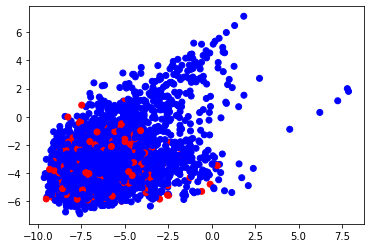

In [24]:
csp_data, labels = decoder.feature_transform();
plt.scatter(csp_data[:,0],csp_data[:,1],color=np.array(["red", "blue"])[np.where(labels == 1, 0, 1)]);

In [25]:
lda = LDADecoder();
lda.fit(csp_data, labels);
print('Accuracy of LDA classifier {}'.format(lda.predict(csp_data, labels)));

Accuracy of LDA classifier 0.920125


## Now we will equalize the number of samples in each class [rare, freq]

In [26]:
data, labels = decoder.get_train(channels=['Cz', 'CPz'], equalize_labels_count=True);
clf_svm_pip = make_pipeline(Vectorizer(), StandardScaler(), svm.SVC(random_state=42))
parameters = {'svc__kernel':['linear', 'rbf', 'sigmoid'], 'svc__C':[0.1, 1, 10]}
gs_cv_svm = GridSearchCV(clf_svm_pip, parameters, scoring='accuracy', cv=StratifiedKFold(n_splits=5), return_train_score=True);
gs_cv_svm.fit(data, labels)
print('Best Parameters: {}'.format(gs_cv_svm.best_params_));
print('Best Score: {}'.format(gs_cv_svm.best_score_));

Best Parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Score: 0.5163970588235294


As expected, equlizing training samples, decreased the Accuracy!

<AxesSubplot:>

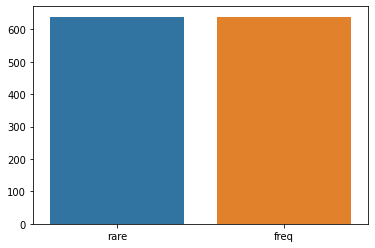

In [27]:
sns.barplot(x=['rare', 'freq'], y=[len(np.where(labels == 1)[0]), len(np.where(labels == 2)[0])])

In [28]:
stim_data = decoder.get_all_stim()
train_data_A, test_data_A, labels_train_A, labels_test_A = train_test_split(stim_data['A']['norm_samples'][0], stim_data['A']['norm_samples'][1], test_size=0.3, random_state=42)
train_data_B, test_data_B, labels_train_B, labels_test_B = train_test_split(stim_data['B']['norm_samples'][0], stim_data['B']['norm_samples'][1], test_size=0.3, random_state=42)
train_data_C, test_data_C, labels_train_C, labels_test_C = train_test_split(stim_data['C']['norm_samples'][0], stim_data['C']['norm_samples'][1], test_size=0.3, random_state=42)
train_data_D, test_data_D, labels_train_D, labels_test_D = train_test_split(stim_data['D']['norm_samples'][0], stim_data['D']['norm_samples'][1], test_size=0.3, random_state=42)
train_data_E, test_data_E, labels_train_E, labels_test_E = train_test_split(stim_data['E']['norm_samples'][0], stim_data['E']['norm_samples'][1], test_size=0.3, random_state=42)

In [29]:

# Linear Discriminant Analysis
scores= []
lda_cv_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
lda = CVPipleline(lda_cv_pip, train_data_A, test_data_A, labels_train_A, labels_test_A)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_B, test_data_B, labels_train_B, labels_test_B)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_C, test_data_A, labels_train_C, labels_test_C)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_D, test_data_D, labels_train_D, labels_test_D)
lda.fit()
lda.predict()
scores.append(lda.evaluate())
lda = CVPipleline(lda_cv_pip, train_data_E, test_data_E, labels_train_E, labels_test_E)
lda.fit()
lda.predict()
scores.append(lda.evaluate())

Clasification Report:
               precision    recall  f1-score   support

        Rare       0.53      0.53      0.53        93
    Frequent       0.56      0.57      0.56        99

    accuracy                           0.55       192
   macro avg       0.55      0.55      0.55       192
weighted avg       0.55      0.55      0.55       192

Accuracy of model: 0.546875
Precision: 0.546304347826087, Recall: 0.5462691430433366, f1-score:0.5462719000407443
Clasification Report:
               precision    recall  f1-score   support

        Rare       0.44      0.58      0.50        83
    Frequent       0.53      0.39      0.45       102

    accuracy                           0.48       185
   macro avg       0.48      0.49      0.47       185
weighted avg       0.49      0.48      0.47       185

Accuracy of model: 0.4756756756756757
Precision: 0.48484848484848486, Recall: 0.48523505787857313, f1-score:0.47469336377740695
Clasification Report:
               precision    recall  

<AxesSubplot:>

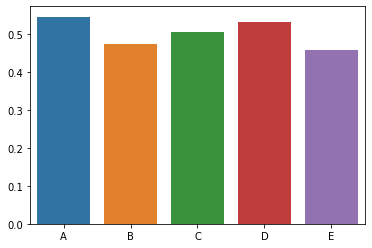

In [30]:
sns.barplot(x=['A', 'B', 'C', 'D', 'E'], y=np.array(scores)[:,0])

Looks like our models are Garbage! I wonder what went wrong

# Classification Over time

In [31]:
pipelines = MultiPipeline(bids_root)
pipelines = pipelines.start_decoding()

100%|██████████| 40/40 [00:45<00:00,  1.13s/it]


In [32]:
subs = { 'id': [], 'times' : [], 'scores': [] } 
for i, pipeline in enumerate(pipelines):
    ecoder = EEGDecoder('stimulus', (-0.1, 0.8), (0.1, 0.7), pipeline.raw, equalize_events=True)
    times, scores = ecoder.run_sliding_()
    subs['times'].append(times)
    subs['scores'].append(scores)
    subs['id'].append(i)

In [33]:
import pandas as pd
df = pd.DataFrame.from_dict(subs)

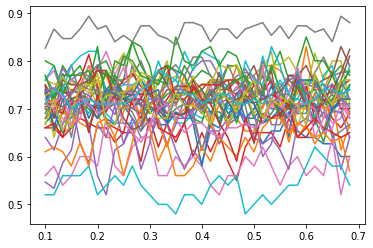

In [34]:
snsdict = {'i':[], 'x':[], 'y' :[]}
for i in range(1, 41):
    id_ = np.ones(df.iloc[i-1].times.shape[0])
    id_.fill(i-1)
    snsdict['i'].extend(id_)
    snsdict['x'].extend(df.iloc[i-1].times.flatten())
    snsdict['y'].extend(df.iloc[i-1].scores.mean(axis=0).flatten())
    plt.plot(df.iloc[i-1].times, df.iloc[i-1].scores.mean(axis=0));
    # sns.lineplot(data=df.iloc[i-1], x='times', y='all_scores', hue='id')

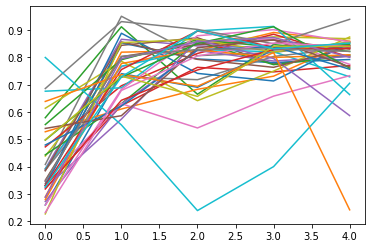

In [35]:
for i in range(1, 41):
    plt.plot(df.iloc[i-1].scores.mean(axis=1));

<AxesSubplot:xlabel='x', ylabel='y'>

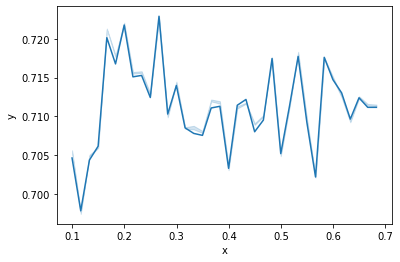

In [40]:
ds = pd.DataFrame.from_dict(snsdict)
sns.lineplot(data=ds, x='x', y='y', ci=.95)

<AxesSubplot:xlabel='x', ylabel='y'>

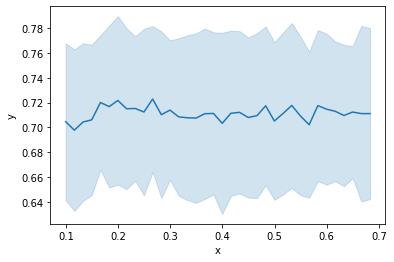

In [37]:
 sns.lineplot(data=ds, x='x', y='y', ci='sd')

In [38]:
svm_scr = []
for i, pipeline in enumerate(pipelines):
    svm_scr.extend(pipeline.decoding_score)

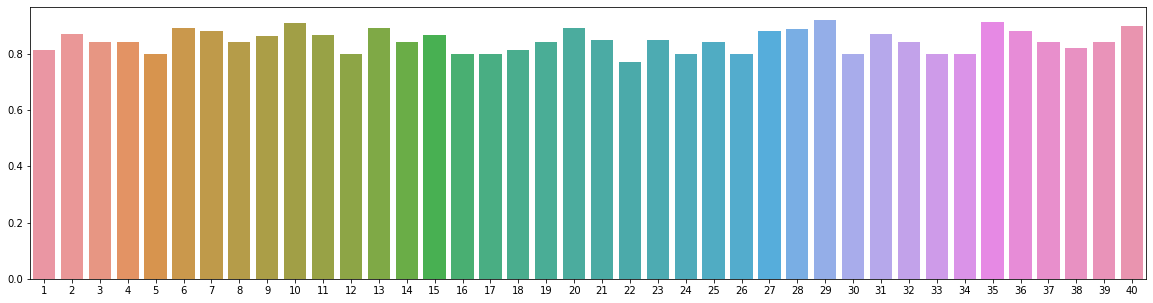

In [39]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.barplot(x=list(range(1,41)), y=svm_scr[::2])